# Passanger Data Set

Importing Libraries

In [100]:
import pandas as pd
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
df = pd.read_csv('Passengers.csv', parse_dates=['Month'])

In [101]:
df

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


EDA on Data Set

In [128]:
def plot_ts(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='limegreen')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

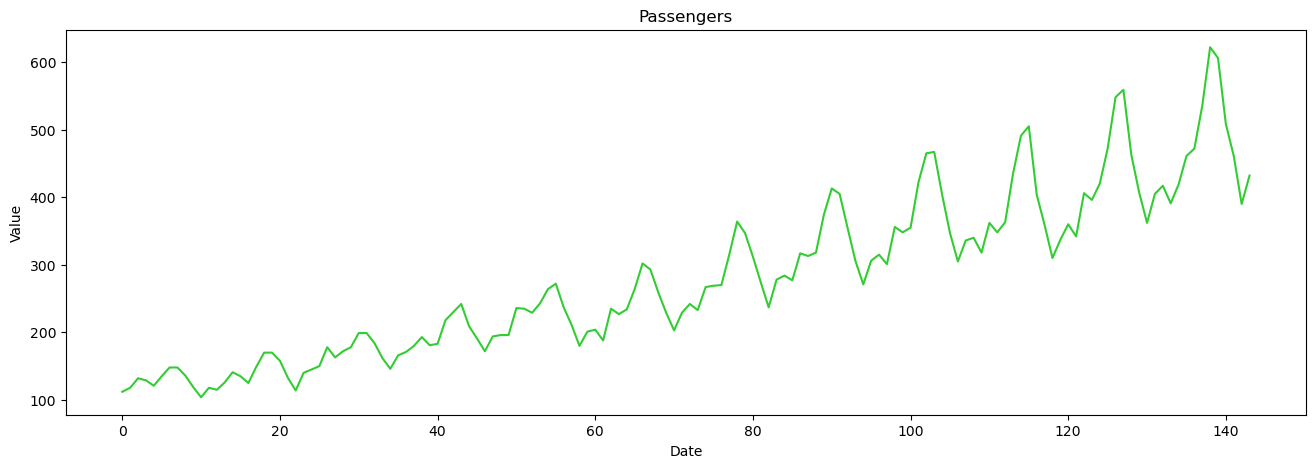

In [129]:
plot_ts(df, x=df.index, y=df["#Passengers"], title="Passengers")

In [102]:
df.info

<bound method DataFrame.info of          Month  #Passengers
0   1949-01-01          112
1   1949-02-01          118
2   1949-03-01          132
3   1949-04-01          129
4   1949-05-01          121
..         ...          ...
139 1960-08-01          606
140 1960-09-01          508
141 1960-10-01          461
142 1960-11-01          390
143 1960-12-01          432

[144 rows x 2 columns]>

<AxesSubplot:>

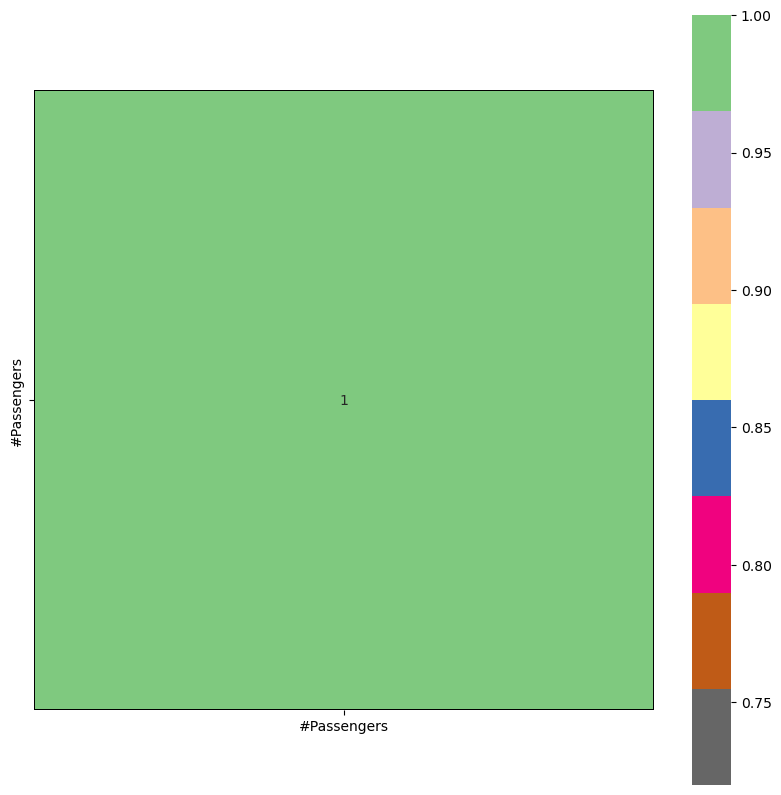

In [103]:
corr=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, vmax=.8, linewidth= 0.01, square= True, annot= True, cmap='Accent_r',linecolor='Black')

To initiate the forecasting process using scalecast, the Forecaster object must be invoked with the parameters y and current_dates defined as inputs. The code snippet below illustrates this process:

In [104]:
f= Forecaster(y= df['#Passengers'],
           current_dates=df['Month'],
           test_length = .3,
           future_dates=30,
           validation_length=5,
           metrics=['rmse','r2'],
           cis=True)
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=30
    Xvars=[]
    TestLength=43
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

To analyze the correlation between the passenger variable (y) and its past values, we can use the PACF (Partial Autocorrelation Function) plot. This plot measures the strength of the correlation between y and its lagged values while controlling for the correlation between intermediate lags. The significance level of the correlation is also determined, indicating how far back in time the correlation remains statistically meaningful.

It is worth noting that the PACF plot serves a different purpose than the ACF (Autocorrelation Function) plot, which measures the correlation between y and its lagged values without controlling for intermediate correlations. While it is recommended to analyze both plots, only the PACF plot will be presented in this post.

C:\Users\abhia\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


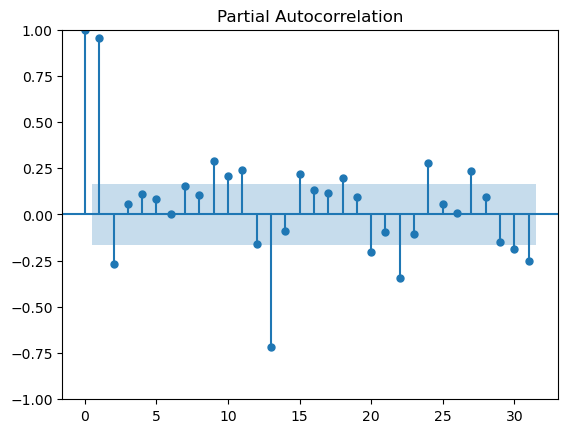

In [105]:
f.plot_pacf(lags=31)
plt.show()

The PACF plot suggests the presence of a statistically significant correlation in the data up to a two-year lag. This information can be valuable while building a model. We can now proceed to decompose the time series into its three components - trend, seasonality, and residual.

To accomplish this, we can apply a decomposition technique that separates the time series into its constituent parts. The trend component represents the long-term behavior of the series, while the seasonal component captures its periodic fluctuations. The residual component comprises all the remaining variation in the data after the trend and seasonality have been accounted for. By decomposing the series, we can better understand its underlying patterns and gain insights for developing an appropriate forecasting model.

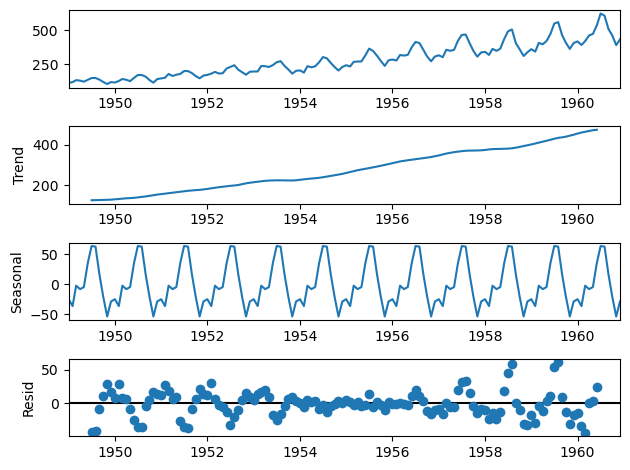

In [106]:
f.seasonal_decompose().plot()
plt.show()

The visual analysis of the decomposed time series reveals a prominent linear trend and a distinct seasonal pattern. Additionally, the residual plot suggests the presence of some underlying pattern, but its nature is not apparent, as expected.

To confirm the stationarity of the time series, we need to perform a formal statistical test. Stationarity refers to the property of a time series where the statistical properties of the series, such as mean, variance, and covariance, remain constant over time. A stationary time series is essential for modeling and forecasting since non-stationary series may exhibit spurious trends, making it challenging to distinguish between short-term fluctuations and long-term changes in the data.

In [107]:
stat, pval, _,_,_,_ = f.adf_test(full_res=True)
print(stat)
print(pval)

0.8153688792060482
0.991880243437641


To perform an LSTM forecast using scalecast, you can use the manual_forecast() method and specify the desired parameters for the model. By default, the LSTM model will have a single input layer of size 8, use the Adam optimizer, have a tanh activation function, be trained with a single lagged dependent variable value, have a learning rate of 0.001, and no dropout.

Before being fed into the model, the data is scaled using a min-max scaler, and then unscaled before being returned.

In [108]:
f.set_test_length(30) 
f.generate_future_dates(12)
f.set_estimator('lstm')

5/5 [==============================] - 0s 1ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

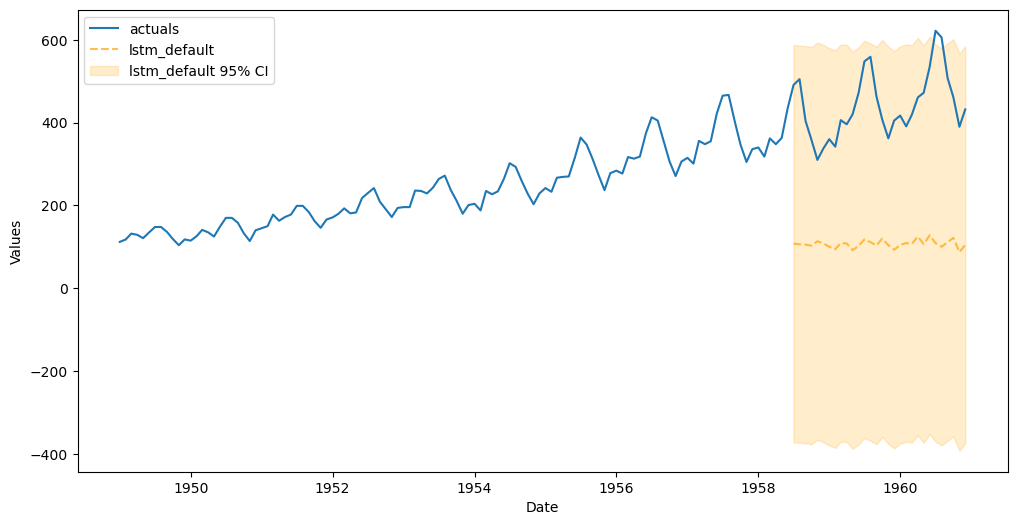

In [109]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

4/4 [==============================] - 0s 2ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

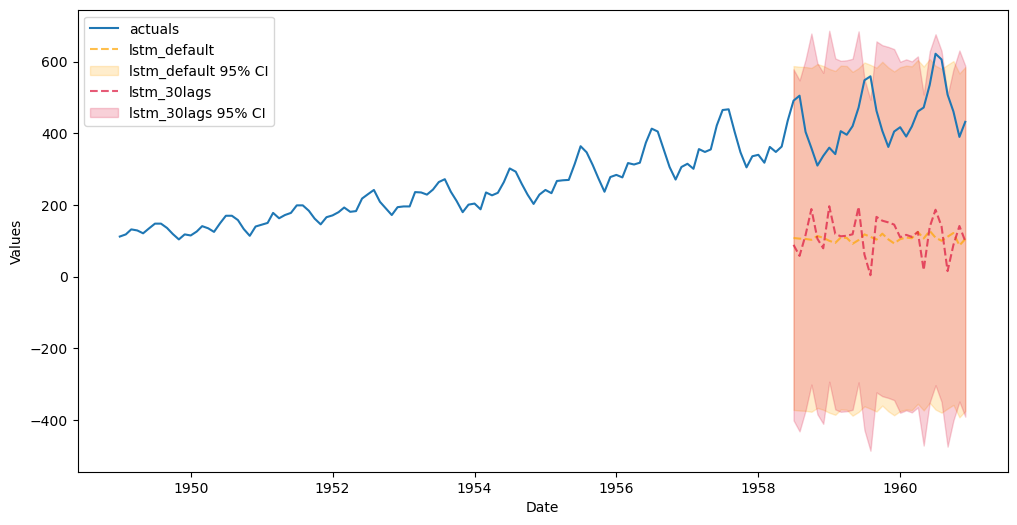

In [110]:
f.manual_forecast(call_me = 'lstm_30lags', lags = 30)
f.plot_test_set(ci=True)

We can improve the LSTM model's performance by increasing the number of epochs used to train the model. In TensorFlow, an epoch refers to one iteration through the entire training dataset. By default, scalecast's manual_forecast() method uses one epoch for training the LSTM model.

To increase the number of epochs, we can pass the "epochs" parameter to the manual_forecast() method. For example, setting "epochs" to 5 will train the model for five epochs. Additionally, we can specify the "validation_split" parameter to validate the model's performance during training. Setting "validation_split" to 0.3, for example, would use 30% of the data for validation during training.

Epoch 1/5
2/2 [==============================] - 1s 305ms/step - loss: 0.3958 - val_loss: 0.6255
Epoch 2/5
2/2 [==============================] - 0s 33ms/step - loss: 0.3926 - val_loss: 0.6216
Epoch 3/5
2/2 [==============================] - 0s 33ms/step - loss: 0.3895 - val_loss: 0.6178
Epoch 4/5
2/2 [==============================] - 0s 32ms/step - loss: 0.3865 - val_loss: 0.6142
Epoch 5/5
1/1 [==============================] - 0s 251ms/step
Epoch 1/5
3/3 [==============================] - 1s 151ms/step - loss: 0.3181 - val_loss: 0.5794
Epoch 2/5
3/3 [==============================] - 0s 19ms/step - loss: 0.3112 - val_loss: 0.5697
Epoch 3/5
3/3 [==============================] - 0s 18ms/step - loss: 0.3041 - val_loss: 0.5595
Epoch 4/5
3/3 [==============================] - 0s 18ms/step - loss: 0.2966 - val_loss: 0.5487
Epoch 5/5
4/4 [==============================] - 0s 2ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

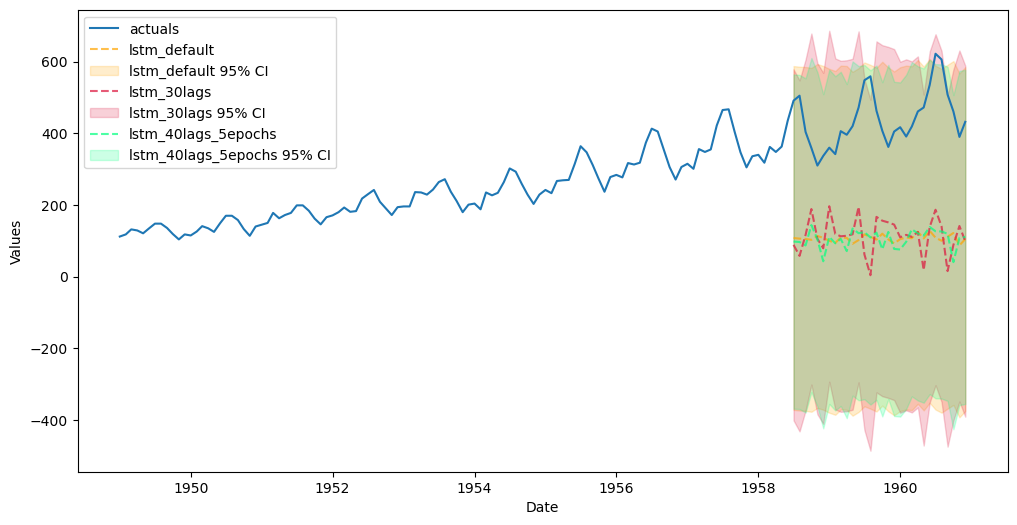

In [111]:
f.manual_forecast(call_me='lstm_40lags_5epochs',
                   lags=30,
                   epochs=5,
                   validation_split=.3,
                   shuffle=True)
f.plot_test_set(ci=True)

Epoch 1/5
2/2 [==============================] - 4s 753ms/step - loss: 0.3893 - val_loss: 0.6079
Epoch 2/5
2/2 [==============================] - 0s 42ms/step - loss: 0.3825 - val_loss: 0.5983
Epoch 3/5
2/2 [==============================] - 0s 41ms/step - loss: 0.3749 - val_loss: 0.5866
Epoch 4/5
2/2 [==============================] - 0s 44ms/step - loss: 0.3656 - val_loss: 0.5717
Epoch 5/5
1/1 [==============================] - 1s 646ms/step
Epoch 1/5
3/3 [==============================] - 4s 350ms/step - loss: 0.3270 - val_loss: 0.5966
Epoch 2/5
3/3 [==============================] - 0s 31ms/step - loss: 0.3152 - val_loss: 0.5800
Epoch 3/5
3/3 [==============================] - 0s 32ms/step - loss: 0.3027 - val_loss: 0.5592
Epoch 4/5
3/3 [==============================] - 0s 30ms/step - loss: 0.2865 - val_loss: 0.5293
Epoch 5/5
4/4 [==============================] - 0s 5ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

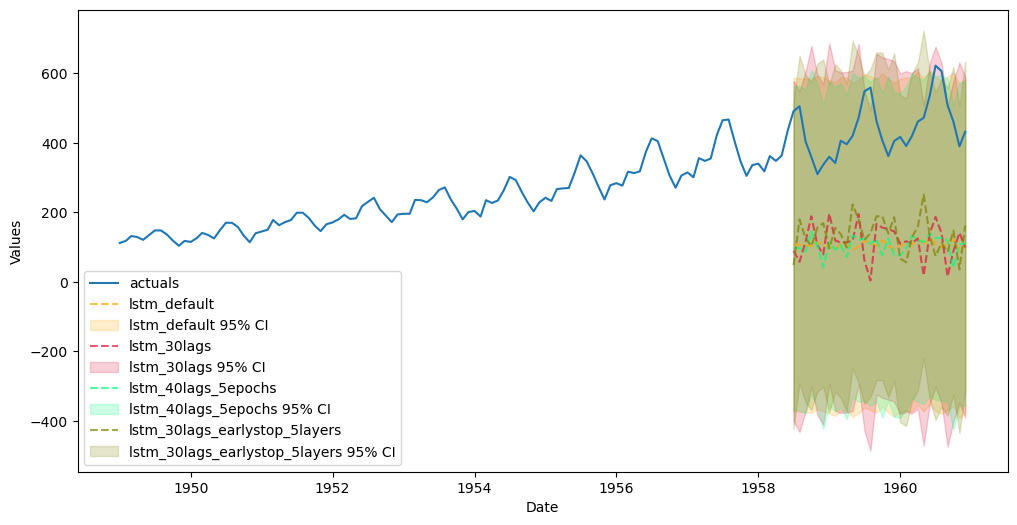

In [112]:
from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(
    call_me = 'lstm_30lags_earlystop_5layers',
    lags=30,
    epochs=5,
    validation_split =.3,
    shuffle=True,
    callbacks= EarlyStopping(monitor='val_loss',
                             patience=5),
                  lstm_layer_sizes=(20,20,20),
                  dropout=(0,0,0)
)
f.plot_test_set(ci=True)

Epoch 1/5
2/2 [==============================] - 8s 1s/step - loss: 0.3850 - val_loss: 0.5852
Epoch 2/5
2/2 [==============================] - 0s 114ms/step - loss: 0.3577 - val_loss: 0.5155
Epoch 3/5
2/2 [==============================] - 0s 119ms/step - loss: 0.2945 - val_loss: 0.3682
Epoch 4/5
2/2 [==============================] - 0s 114ms/step - loss: 0.2225 - val_loss: 0.2866
Epoch 5/5
1/1 [==============================] - 1s 1s/step


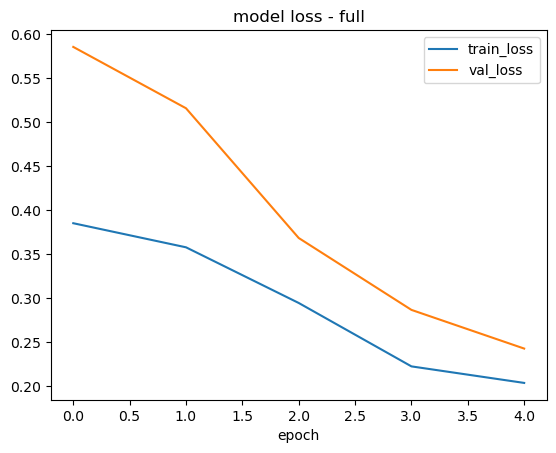

Epoch 1/5
4/4 [==============================] - 6s 413ms/step - loss: 0.3071 - val_loss: 0.4720
Epoch 2/5
4/4 [==============================] - 0s 85ms/step - loss: 0.1879 - val_loss: 0.2176
Epoch 3/5
4/4 [==============================] - 0s 111ms/step - loss: 0.1053 - val_loss: 0.2103
Epoch 4/5
4/4 [==============================] - 0s 90ms/step - loss: 0.0920 - val_loss: 0.1474
Epoch 5/5
4/4 [==============================] - 0s 24ms/step


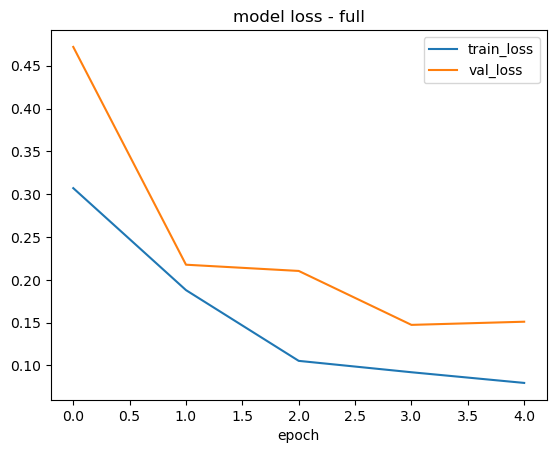

<AxesSubplot:xlabel='Date', ylabel='Values'>

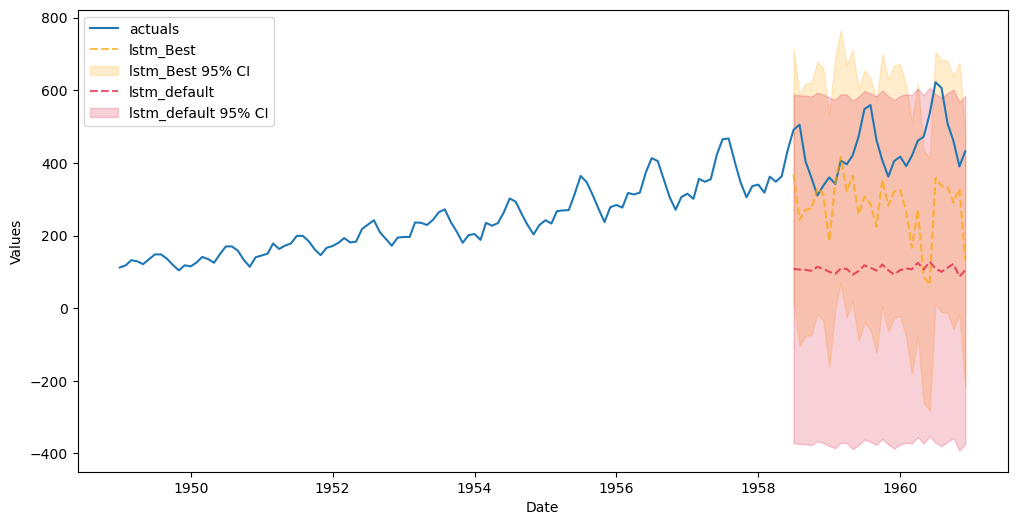

In [113]:
f.manual_forecast(call_me='lstm_Best',
                 lags=30,
                 batch_size=20,
                 epochs=5,
                 validation_split=.3,
                 shuffle=True,
                 activation='tanh',
                 optimizer='Adam',
                 learning_rate=0.001,
                 lstm_layer_sizes=(72,)*4,
                 dropout=(0,)*4,
                 plot_loss=True)
f.plot_test_set(order_by='InSampleRMSE',models='top_2', ci=True)

# MLR Forecasting and Model Benchmarking

In [114]:
from scalecast.SeriesTransformer import SeriesTransformer

transformer = SeriesTransformer(f)
f= transformer.DiffTransform()
f.add_ar_terms(40)
f.add_seasonal_regressors('month',dummy=True)
f.add_time_trend()

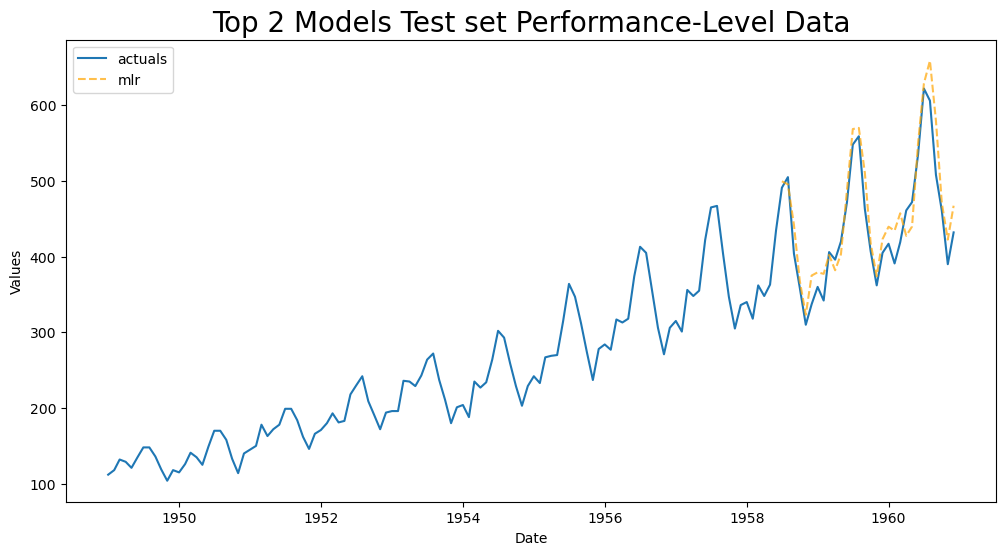

In [115]:
f.set_estimator('mlr')
f.manual_forecast()

f = transformer.DiffRevert(
    exclude_models = [ m for m in f.history if m != 'mlr']
)
f.plot_test_set(order_by='InSampleRMSE', models=['lstm_best','mlr'])
plt.title('Top 2 Models Test set Performance-Level Data',size=20)
plt.show()

In [117]:
f.export('model_summaries',determine_best_by='TestSetRMSE')[
    ['ModelNickname','best_model']
]

,ModelNickname,best_model
0,mlr,True
1,lstm_Best,False
2,lstm_30lags_earlystop_5layers,False
3,lstm_30lags,False
4,lstm_default,False
5,lstm_40lags_5epochs,False


In [118]:
f.export('model_summaries',determine_best_by='TestSetR2')[
    ['ModelNickname','best_model']
]

,ModelNickname,best_model
0,mlr,True
1,lstm_Best,False
2,lstm_30lags_earlystop_5layers,False
3,lstm_30lags,False
4,lstm_default,False
5,lstm_40lags_5epochs,False


In [130]:
f.export('model_summaries',determine_best_by='InSampleRMSE')[
    ['ModelNickname','best_model']
]

,ModelNickname,best_model
0,mlr,True
1,lstm_Best,False
2,lstm_default,False
3,lstm_30lags_earlystop_5layers,False
4,lstm_30lags,False
5,lstm_40lags_5epochs,False


The scalecast package employs a dynamic forecasting and testing approach that combines AR/lagged values with its own predictions in a manner that eliminates the risk of data leakage.

In conclusion, this brief introduction to modeling with LSTM in scalecast demonstrates that it is not always advisable to immediately adopt the most advanced method for a given problem. Instead, simpler models can often offer superior speed, interpretability, and overall performance.